In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# LSTM Model
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM

Using TensorFlow backend.


In [2]:
data_path = os.path.join(os.getcwd(), 'data')
data_path

'C:\\Users\\lynkx\\Python Projects\\BB\\data'

In [3]:
df_kpis = pd.read_excel(os.path.join(data_path, 'analisi.xlsx'), sheetname='KPIs')
df_spending = pd.read_excel(os.path.join(data_path, 'analisi.xlsx'), sheetname='Spending')

In [4]:
df_kpis.sort_values(by='Date', inplace=True)
df_spending.sort_values(by='Date', inplace=True)

# Drop K5, because it's another response variable
df_kpis.drop('K5', axis=1, inplace=True)

In [5]:
# Date metric
df_kpis.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 932 entries, 0 to 931
Data columns (total 11 columns):
Date    932 non-null datetime64[ns]
K1      932 non-null int64
K2      932 non-null int64
K3      932 non-null int64
K4      932 non-null int64
K6      932 non-null int64
K7      932 non-null int64
K8      932 non-null int64
K9      932 non-null float64
K10     932 non-null float64
K11     932 non-null float64
dtypes: datetime64[ns](1), float64(3), int64(7)
memory usage: 87.4 KB


In [6]:
df_kpis['month'] = df_kpis['Date'].dt.month
df_kpis['year'] = df_kpis['Date'].dt.year
df_kpis['weekday'] = df_kpis['Date'].dt.weekday
df_kpis['days_in_month'] = df_kpis['Date'].dt.daysinmonth

In [7]:
df_kpis_date = df_kpis['Date']
df_kpis.index = df_kpis_date
df_kpis.drop('Date', axis=1, inplace=True)

In [8]:
df_kpis.head()

,K1,K2,K3,K4,K6,K7,K8,K9,K10,K11,month,year,weekday,days_in_month
Date,,,,,,,,,,,,,,
2015-03-16,0,0,155,0,379,195,923,3.030303,0.210184,0.333333,3,2015,0,31
2015-03-17,1,8,1074,34,658,468,3563,4.532667,0.370474,0.301205,3,2015,1,31
2015-03-18,0,10,1129,46,652,493,3679,4.902364,0.366676,0.288462,3,2015,2,31
2015-03-19,0,7,1107,33,597,522,3517,4.775744,0.355701,0.385714,3,2015,3,31
2015-03-20,0,13,1116,143,606,453,3815,4.228381,0.388991,0.678571,3,2015,4,31


In [9]:
df_spending['month'] = df_spending['Date'].dt.month
df_spending['year'] = df_spending['Date'].dt.year
df_spending['days_in_month'] = df_spending['Date'].dt.daysinmonth
df_spending.index = df_spending['Date']
df_spending.drop('Date', axis=1, inplace=True)

In [10]:
df_spending['avgE1'] = df_spending['E1']/df_spending['days_in_month']
df_spending['avgE2'] = df_spending['E2']/df_spending['days_in_month']

In [11]:
df_kpis = df_kpis.merge(df_spending[['year', 'month', 'avgE1', 'avgE2']], on=['year', 'month'],
                        how='inner')
df_kpis.index = df_kpis_date

In [12]:
df_kpis.head()

,K1,K2,K3,K4,K6,K7,K8,K9,K10,K11,month,year,weekday,days_in_month,avgE1,avgE2
Date,,,,,,,,,,,,,,,,
2015-03-16,0,0,155,0,379,195,923,3.030303,0.210184,0.333333,3,2015,0,31,530.129032,4403.387097
2015-03-17,1,8,1074,34,658,468,3563,4.532667,0.370474,0.301205,3,2015,1,31,530.129032,4403.387097
2015-03-18,0,10,1129,46,652,493,3679,4.902364,0.366676,0.288462,3,2015,2,31,530.129032,4403.387097
2015-03-19,0,7,1107,33,597,522,3517,4.775744,0.355701,0.385714,3,2015,3,31,530.129032,4403.387097
2015-03-20,0,13,1116,143,606,453,3815,4.228381,0.388991,0.678571,3,2015,4,31,530.129032,4403.387097


In [13]:
df_kpis.shape

(932, 16)

In [14]:
cols_list = [i for i in df_kpis.columns if i[0] == 'K']
cols_list.append('avgE1')
cols_list.append('avgE2')

In [15]:
print(cols_list)

['K1', 'K2', 'K3', 'K4', 'K6', 'K7', 'K8', 'K9', 'K10', 'K11', 'avgE1', 'avgE2']


In [16]:
logs = np.log1p(df_kpis[cols_list])
logs.head()

,K1,K2,K3,K4,K6,K7,K8,K9,K10,K11,avgE1,avgE2
Date,,,,,,,,,,,,
2015-03-16,0.000000,0.000000,5.049856,0.000000,5.940171,5.278115,6.828712,1.393842,0.190773,0.287682,6.275005,8.390356
2015-03-17,0.693147,2.197225,6.980076,3.555348,6.490724,6.150603,8.178639,1.710670,0.315157,0.263291,6.275005,8.390356
2015-03-18,0.000000,2.397895,7.029973,3.850148,6.481577,6.202536,8.210668,1.775353,0.312381,0.253449,6.275005,8.390356
2015-03-19,0.000000,2.079442,7.010312,3.526361,6.393591,6.259581,8.165648,1.753667,0.304319,0.326216,6.275005,8.390356
2015-03-20,0.000000,2.639057,7.018402,4.969813,6.408529,6.118097,8.246958,1.654102,0.328577,0.517943,6.275005,8.390356


In [17]:
dummies = pd.get_dummies(df_kpis[['month', 'weekday']].astype(str))
dummies.head()

,month_1,month_10,month_11,month_12,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
Date,,,,,,,,,,,,,,,,,,,
2015-03-16,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
2015-03-17,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
2015-03-18,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
2015-03-19,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
2015-03-20,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0


In [18]:
df = pd.concat([logs, dummies], axis=1)
print(df.shape)
print(df.columns)

(932, 31)
Index(['K1', 'K2', 'K3', 'K4', 'K6', 'K7', 'K8', 'K9', 'K10', 'K11', 'avgE1',
       'avgE2', 'month_1', 'month_10', 'month_11', 'month_12', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3',
       'weekday_4', 'weekday_5', 'weekday_6'],
      dtype='object')


In [93]:
def lagger(df, lag=1):
    dfs = df.shift(lag)
    new_cols = []
    for col in dfs.columns:
        new_cols.append(col + '_lag{}'.format(str(lag).zfill(2)))
    dfs.columns = new_cols
    return dfs

In [114]:
df_shifted = lagger(df, 1)
df_shifted2 = lagger(df, 2)
df_shifted3 = lagger(df, 3)
df_shifted4 = lagger(df, 4)
df_shifted7 = lagger(df, 7)
df_shifted14 = lagger(df, 14)

df_shifted = pd.concat([df, df_shifted, df_shifted2, df_shifted3], axis=1)
# df_shifted = pd.concat([df, df_shifted, df_shifted2, df_shifted3, df_shifted4], axis=1)

#df_shifted = pd.concat([df, df_shifted7, df_shifted14], axis=1)
df_shifted.drop(df_shifted[df_shifted['K11_lag03'].isnull() == True].index, axis=0, inplace=True)
df_shifted.head()

,K1,K2,K3,K4,K6,K7,K8,K9,K10,K11,...,month_7_lag03,month_8_lag03,month_9_lag03,weekday_0_lag03,weekday_1_lag03,weekday_2_lag03,weekday_3_lag03,weekday_4_lag03,weekday_5_lag03,weekday_6_lag03
Date,,,,,,,,,,,,,,,,,,,,,
2015-03-19,0.000000,2.079442,7.010312,3.526361,6.393591,6.259581,8.165648,1.753667,0.304319,0.326216,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-03-20,0.000000,2.639057,7.018402,4.969813,6.408529,6.118097,8.246958,1.654102,0.328577,0.517943,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2015-03-21,0.000000,2.079442,6.192362,5.036953,6.361302,6.018593,8.032360,1.612994,0.384232,0.365934,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2015-03-22,0.693147,1.945910,6.291569,5.003946,6.546785,6.030685,8.145260,1.677052,0.389474,0.228534,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2015-03-23,0.693147,2.564949,7.264030,9.421411,6.999422,6.278521,9.784028,1.738018,0.123408,0.378973,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [115]:
train = df_shifted[df_shifted.index < '2017-09-01']
test = df_shifted[df_shifted.index >= '2017-09-01']

In [116]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [117]:
scaled_train = pd.DataFrame(scaler.transform(train), columns=train.columns, index=train.index)
scaled_test = pd.DataFrame(scaler.transform(test), columns=test.columns, index=test.index)

In [118]:
# new_train = pd.concat([scaled_train, train.drop(cols_list, axis=1).head()], axis=1)
# new_test = pd.concat([scaled_test, test.drop(cols_list, axis=1).head()], axis=1)
new_train = scaled_train
new_test = scaled_test

In [119]:
X_train = new_train.drop('K11', axis=1)
y_train = new_train['K11']

X_test = new_test.drop('K11', axis=1)
y_test = new_test['K11']

In [120]:
X_train = X_train.values.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.values.reshape(X_test.shape[0], 1, X_test.shape[1])

In [121]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(897, 1, 123) (897,) (32, 1, 123) (32,)


In [126]:
# design network
model = Sequential()
model.add(LSTM(14, input_shape=(X_train.shape[1], X_train.shape[2])))
# model.add(Dense(10))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

# fit the network
history = model.fit(X_train, y_train, epochs=100, batch_size=7, validation_data=(X_test, y_test),
                    verbose=1, shuffle=False)

Train on 897 samples, validate on 32 samples
Epoch 1/100
897/897 [==============================] - 2s - loss: 0.0332 - val_loss: 0.0421
Epoch 2/100
897/897 [==============================] - 0s - loss: 0.0185 - val_loss: 0.0499
Epoch 3/100
897/897 [==============================] - 0s - loss: 0.0160 - val_loss: 0.0498
Epoch 4/100
897/897 [==============================] - 0s - loss: 0.0148 - val_loss: 0.0479
Epoch 5/100
897/897 [==============================] - 0s - loss: 0.0145 - val_loss: 0.0477
Epoch 6/100
897/897 [==============================] - 1s - loss: 0.0144 - val_loss: 0.0491
Epoch 7/100
897/897 [==============================] - 0s - loss: 0.0141 - val_loss: 0.0502
Epoch 8/100
897/897 [==============================] - 0s - loss: 0.0135 - val_loss: 0.0499
Epoch 9/100
897/897 [==============================] - 0s - loss: 0.0130 - val_loss: 0.0487
Epoch 10/100
897/897 [==============================] - 0s - loss: 0.0125 - val_loss: 0.0476
Epoch 11/100
897/897 [============

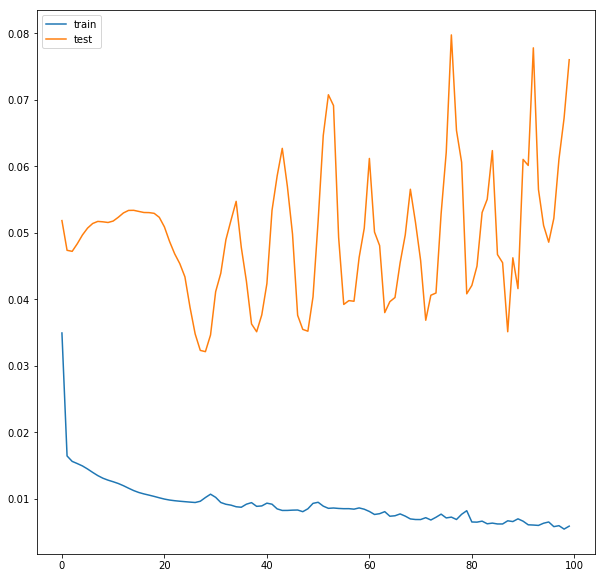

In [123]:
# plot history
plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

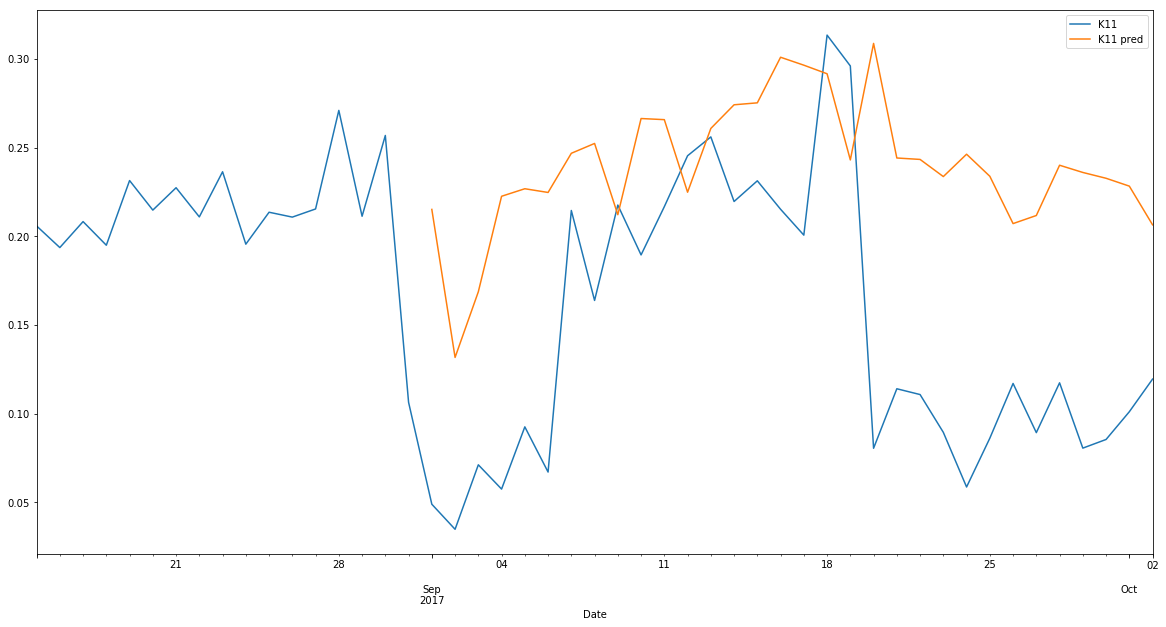

In [124]:
y_pred = model.predict(X_test, batch_size=10)
# y_pred = scaler.inverse_transform(y_pred)
test2 = pd.DataFrame(test.values, columns=test.columns, index=test.index)
test2.loc[:, 'K11'] = y_pred

test2 = pd.DataFrame(scaler.inverse_transform(test2), columns=test.columns, index=test.index)

y_pred = test2['K11']
# y_pred

finals = pd.DataFrame(pd.concat([df_shifted['K11'], y_pred], axis=1))
finals.columns = ['K11', 'K11 pred']

finals[finals.index >= '2017-08-15'].plot(figsize=(20,10))

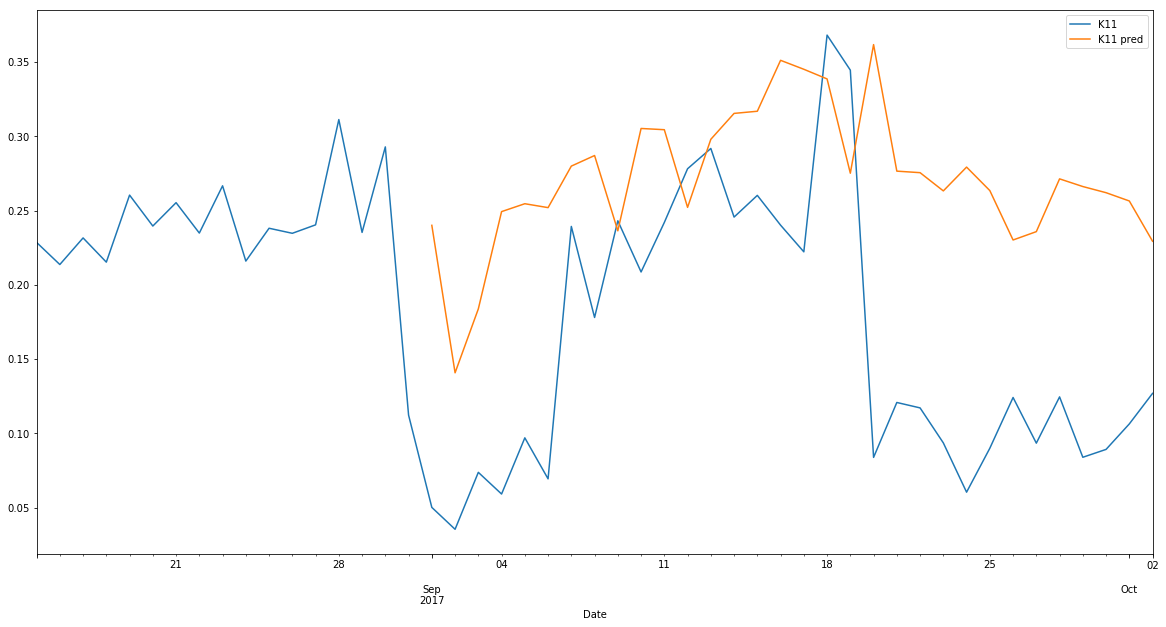

In [125]:
finals_exp = np.exp(finals) - 1
# finals_exp
finals_exp[finals_exp.index >= '2017-08-15'].plot(figsize=(20,10))